<a href="https://www.kaggle.com/code/zrosen3/housing-prices-rosen?scriptVersionId=97154999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initial data exploration

Load in packages.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #for graphs
import matplotlib.pyplot as plt  #for graphs
from scipy.stats import chi2_contingency  #for performing chi squared test
from sklearn.feature_selection import VarianceThreshold #to split variables into differnet groups



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Load in data

In [2]:
#description = pd.read_txt("../input/house-prices-advanced-regression-techniques/data_description.txt")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
sample = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

View each dataframe

In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


Look at distribution of sales price, our target variable. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


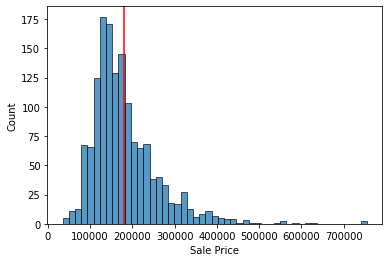

In [6]:
sns.histplot(
    train["SalePrice"]
).set(xlabel = 'Sale Price', ylabel = 'Count')
plt.axvline(x = train["SalePrice"].mean(), color = "red")
print(train['SalePrice'].describe())

Sale price seems to have a right skew, with most prices between $100,000-$300,000 and a few high outliers.

# Investigate missing values.

In [7]:
missing_variables = train[train.columns[train.isnull().any()]]
missing_variables.isnull().sum()
missing_variables.dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

Drop variables with over half missing values.

In [8]:
train = train.dropna(axis=1, thresh = len(train)/2)

Fill remaining numeric values with median, categorical with mode

In [9]:
for df in (train,test):
  numeric_columns = df.select_dtypes(include = 'number').columns
  string_columns = df.select_dtypes(include = 'object').columns
  df[numeric_columns] = df[numeric_columns].fillna('Median')
  df[string_columns] = df[string_columns].fillna('Mode')
    


# Choosing numeric variables

There are lots of variables. Let's make this problem more manageable by looking at different types of variables. First, look at numerical values, try to see which ones are correlated with housing prices. If not correlated, then drop variable. Note that ID will not be treated as numeric.

In [10]:
numeric_columns = train.select_dtypes(include = np.number)
numeric_columns = numeric_columns.drop("Id", axis = 1)
numeric_columns

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,2000,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,366,0,112,0,0,0,0,4,2010,142125


I will draw a bunch of histograms to get a sense ot the distribution of these numeric variables. 

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>],
       [<AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>,
        <AxesSubplot:title={'center':'FullBath'}>,
        <AxesSubplot:title={'center':'HalfBath'}>],
       [<AxesSubplot:title={'center':'BedroomA

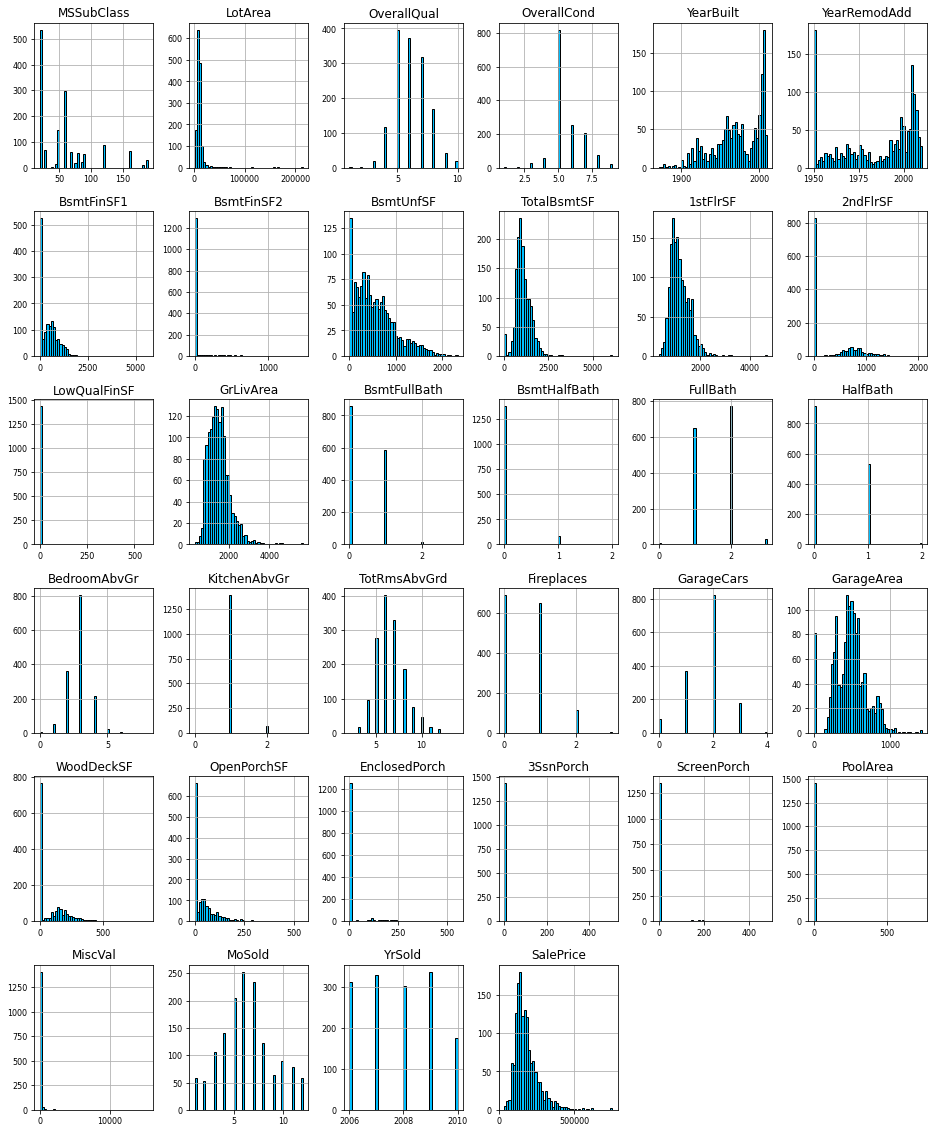

In [11]:
numeric_columns.hist(figsize = (16, 20), bins = 50, color = "deepskyblue", edgecolor = "black", xlabelsize =8, ylabelsize = 8)

Create correlation matrix, look at variables correlated with saleprice.

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


<AxesSubplot:>

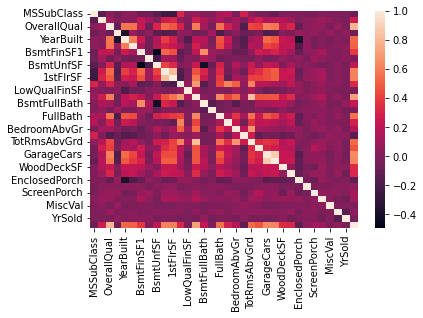

In [12]:
corr_matrix=numeric_columns.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot = False)


Only select highly correlated features.

In [13]:
cut_off = 0.5
cor_values = abs(corr_matrix["SalePrice"])
relevant_numerics = cor_values[cor_values > cut_off]
relevant_numerics


OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

Now we have values highly correlated with saleprice. Let's filter to these highly correlated variables and create a correlation matrix to check if independent variables are uncorrelated.

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


<AxesSubplot:>

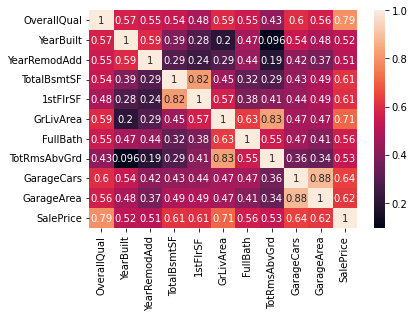

In [14]:
numeric_columns = numeric_columns[list(relevant_numerics.index)]
corr_matrix=numeric_columns.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot = True)


There seems to be a few numeric variables that are highly correlated with one another. OverallQual is highly correlated with SalePrice, which is not an issue since SalePrice is our target variable. 

GarageCars and GarageArea have a correlation of 0.88. The garage correlation seems most troubling, and intuitively these variables shouldn't contain much different information. Let's drop garage cars.

In [15]:
numeric_columns = numeric_columns.drop("GarageCars", axis = 1)

# Categorical variable exploration

Now, we've found the numeric variables we want to include in our model. Let's take a look at the categorical variables to see which ones seem to impact sale price.

In [16]:
categorical_data = train.select_dtypes(include =object)

I will create a series of count plots to get a sense of the distribution of these categorical variables.

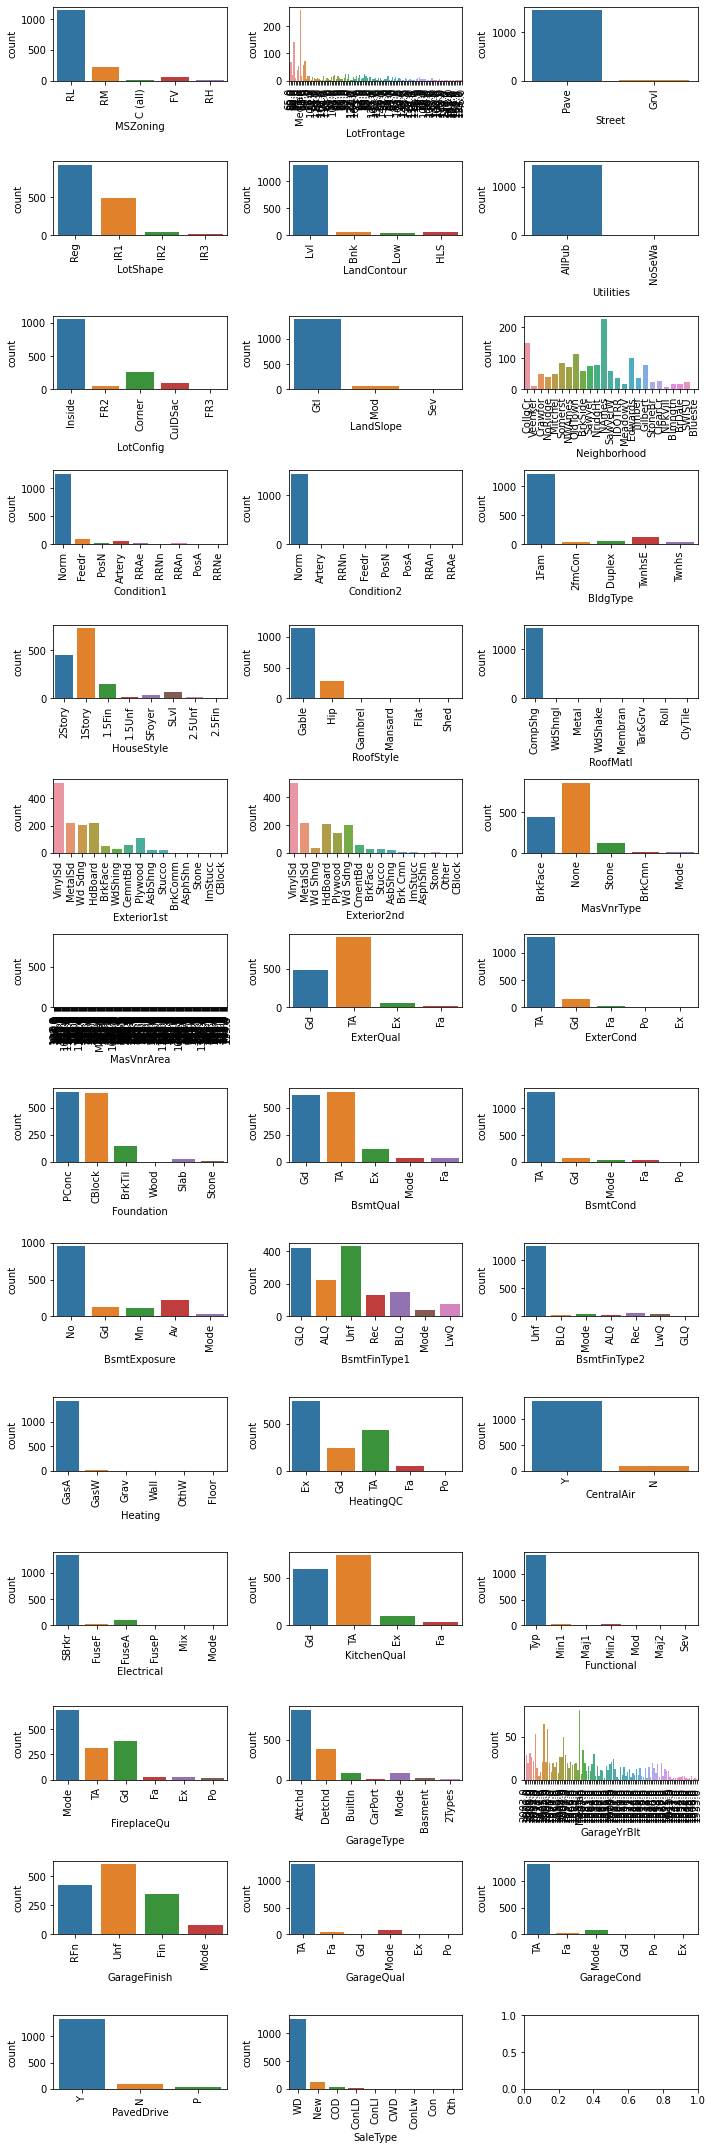

In [17]:
fig, axes = plt.subplots(round(len(categorical_data.columns)/3),3, figsize = (10, 30))
for i, ax in enumerate(fig.axes):
    if i < len(categorical_data.columns)-1:
        sns.countplot(x = categorical_data.columns[i], ax = ax, data = categorical_data)
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
fig.tight_layout()



Look at variables which are mainly constant (>95% values in one category) and remove from dataset, since unlikely to produce meaningful variation. 

In [18]:
for col in categorical_data.columns:
    if categorical_data[col].value_counts(normalize = True).max() > 0.95:
        print("Dropping column " + col )
        categorical_data = categorical_data.drop(col, axis = 1)



Dropping column Street
Dropping column Utilities
Dropping column Condition2
Dropping column RoofMatl
Dropping column Heating


Exterior first and exterior second seem to follow very similar distributions. Perform Chi-Squared test to see if two events are independent. If not independent, drop Exterior2nd.

In [19]:
contingency_table = pd.crosstab(categorical_data["Exterior1st"], categorical_data["Exterior2nd"], margins = True)
stat, p, dof, expected = chi2_contingency(contingency_table)
if p < 0.05:
    print("Dropping Exterior2nd, chi-squared test shows not independent of Exterior1st")
    categorical_data= categorical_data.drop("Exterior2nd", axis =1)


Dropping Exterior2nd, chi-squared test shows not independent of Exterior1st


Perform Chi-Squared test to see if categorical variables likely have an impact on sales price.

In [20]:
cols_to_drop = []
significance = .05
for i in  range(1, len(categorical_data.columns)):
    for j in  range(i+1, len(categorical_data.columns)):
        col1 = categorical_data.columns[i]
        col2 = categorical_data.columns[j]
        contingency_table = pd.crosstab(categorical_data[col1], categorical_data[col2], margins = True)
        stat, p, dof, expected = chi2_contingency(contingency_table)
        if p < significance and col1 not in cols_to_drop:
            print("Columns " + col1 + " and " + col2 + " are not independent")
            cols_to_drop.append(col2)
        
    

Columns LotFrontage and LotShape are not independent
Columns LotFrontage and LotConfig are not independent
Columns LotFrontage and Neighborhood are not independent
Columns LotFrontage and BldgType are not independent
Columns LotFrontage and Exterior1st are not independent
Columns LotFrontage and MasVnrType are not independent
Columns LotFrontage and MasVnrArea are not independent
Columns LotFrontage and ExterQual are not independent
Columns LotFrontage and Foundation are not independent
Columns LotFrontage and BsmtQual are not independent
Columns LotFrontage and KitchenQual are not independent
Columns LotFrontage and FireplaceQu are not independent
Columns LotFrontage and GarageType are not independent
Columns LotFrontage and GarageYrBlt are not independent
Columns LotFrontage and GarageFinish are not independent
Columns LandContour and LandSlope are not independent
Columns LandContour and Neighborhood are not independent
Columns LandContour and BldgType are not independent
Columns Lan

Drop categorical variables based on results of chi-squared test.

In [21]:
cols_to_drop = list(set(cols_to_drop))
categorical_data = categorical_data.drop(cols_to_drop, axis = 1)

Look at distribution of sale price within categorical variables. 

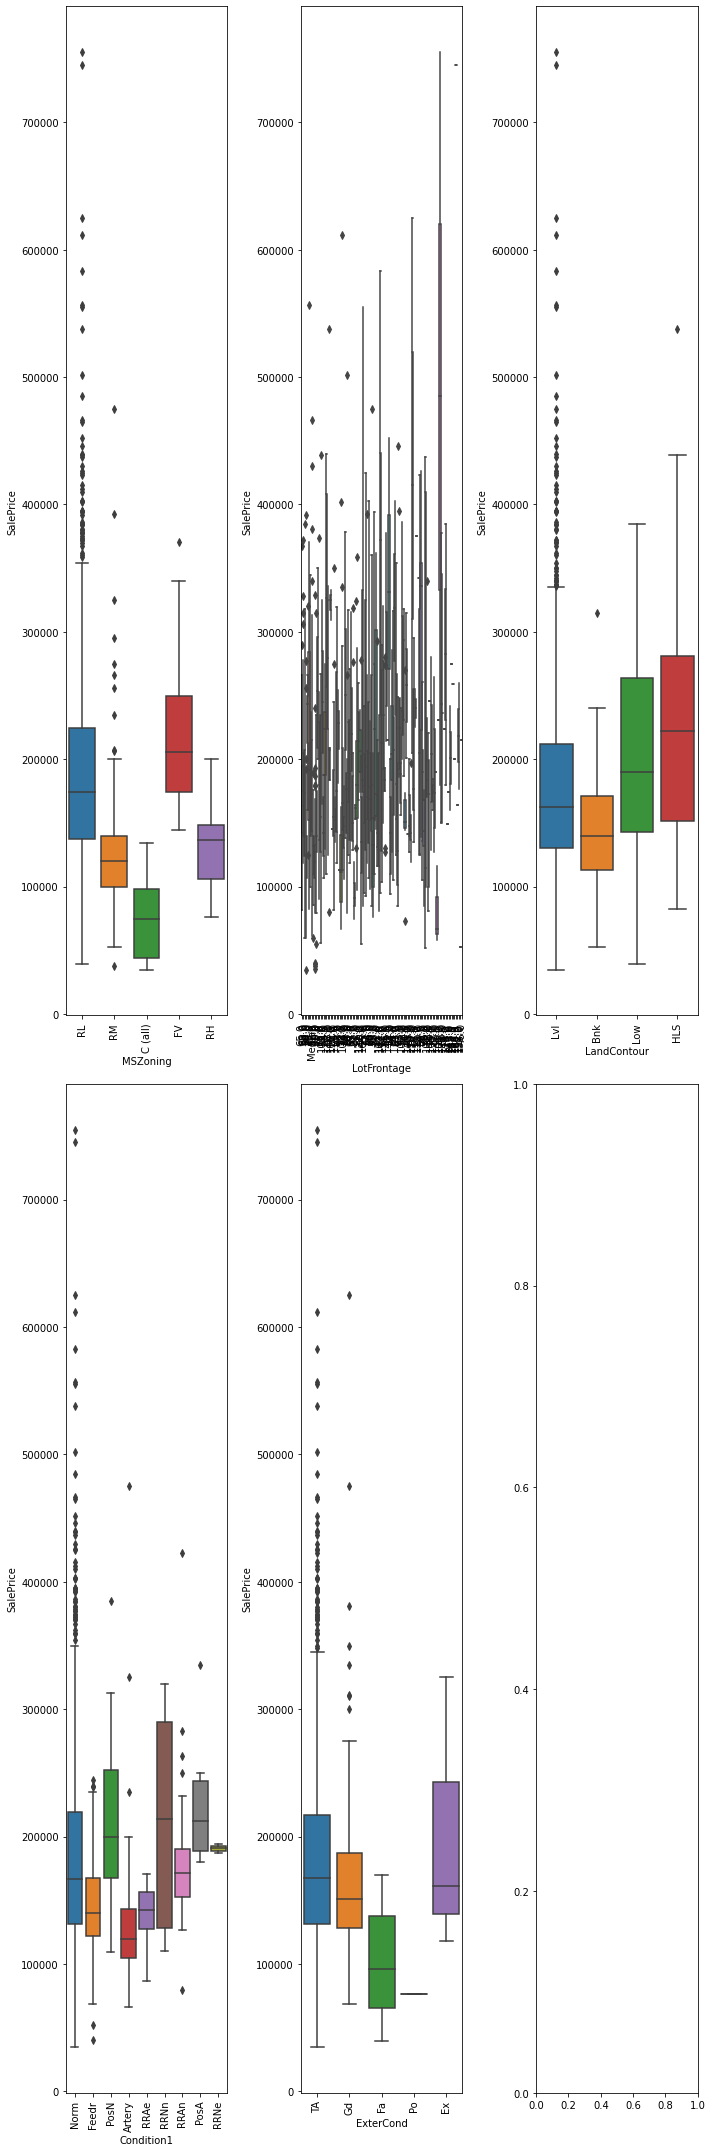

In [22]:
fig, axes = plt.subplots(round(len(categorical_data.columns)/3),3, figsize = (10, 30))
for i, ax in enumerate(fig.axes):
    if i < len(categorical_data.columns)-1:
        sns.boxplot(x = train[categorical_data.columns[i]], ax = ax, y = train["SalePrice"])
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
fig.tight_layout()



# Modelling

Select categorical and numerical variables from train and test data 

In [23]:
numeric_columns
categoric_columns = categorical_data.columns
cols = [list(numeric_columns), list(categoric_columns), ["Id"]]
cols_to_keep = [feature  for l in cols for feature in l]
train = train[cols_to_keep]
cols_to_keep2 = cols_to_keep.remove("SalePrice")
test = test[cols_to_keep]





Run random forest model.

In [24]:
##model
import copy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
y = train["SalePrice"]
features= test.columns.drop("Id")

last_row_train = len(train)
combined = pd.concat(objs=[train,test], axis = 0)
combined_dummies = pd.get_dummies(combined[test.columns])
X = copy.copy(combined_dummies[:last_row_train])
X_test = copy.copy(combined_dummies[last_row_train:])

#only keep columns found in both datasets
common_cols = np.intersect1d(X.columns, X_test.columns)
X= X[common_cols]
X_test = X_test[common_cols]

                             
#calculate predictions
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)                                                                                                                                                           
predictions = model.predict(X_test)

In [25]:
##submission
output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
